In [1]:
import numpy as np
import json
import os
from glob import glob

from attention.common_code.common import jsd
from attention.common_code.plotting import annotate, \
    plot_violin_by_class, plot_scatter_by_class, \
    init_gridspec, adjust_gridspec, show_gridspec, \
    save_axis_in_file
from attention.Trainers.DatasetBC import datasets

In [2]:
data_name = 'sst'
model_type = 'lstm+tanh'
dataset = datasets[data_name]({'encoder':'lstm', 'attention':'tanh','data_dir':'.'})
test_data = dataset.test_data

/nethome/ypinter3/.local/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.20.1 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [3]:
base_dir = glob(f'outputs/{data_name}/{model_type}/*')[0]

In [4]:
yhat_orig = json.load(open(os.path.join(base_dir, 'test_attentions_best_epoch.json')))
yhat_preds_orig = json.load(open(os.path.join(base_dir, 'test_predictions_best_epoch.json')))

In [5]:
len(yhat_orig)

1725

In [6]:
yhat_seeds = []
yhat_preds_seeds = []
for sd in glob(f'outputs/seed_*/{data_name}/{model_type}/*'):
    yhat_seeds.append(json.load(open(os.path.join(sd, 'test_attentions_best_epoch.json'))))
    yhat_preds_seeds.append(json.load(open(os.path.join(sd, 'test_predictions_best_epoch.json'))))

In [7]:
yhat_orig[0]

[0.0,
 0.7365987300872803,
 0.09295983612537384,
 0.047137267887592316,
 0.03194161877036095,
 0.05780043080449104,
 0.03356209024786949,
 0.0]

In [8]:
yhat_seeds[0][0]

[0.0,
 0.7535899877548218,
 0.12045961618423462,
 0.041543472558259964,
 0.038531530648469925,
 0.026886137202382088,
 0.018989231437444687,
 0.0]

In [9]:
def numpify(yh):
    return np.array([np.array(att[1:-1]) for att in yh])

In [10]:
# DO NOT RUN MORE THAN ONCE
yhat_orig = numpify(yhat_orig)
yhat_seeds = [numpify(sd) for sd in yhat_seeds]

In [11]:
num_rands = len(yhat_seeds)
output_size = len(set(test_data.y)) # maybe for later
seed_atts = np.zeros((num_rands, len(test_data.y), 1))
max_attn = np.zeros((num_rands, len(test_data.y)))
for i, yhs in enumerate(yhat_seeds):
    for j in range(len(test_data.y)):
        seed_atts[i,j,0] = jsd(yhat_orig[j], yhs[j])
        max_attn[i,j] = max(yhs[j])
max_attn = np.median(max_attn, 0)

In [12]:
attn_diff = np.abs(seed_atts - yhat_preds_orig).mean(-1)
attn_diff = np.median(attn_diff, 0)

y_diff = np.abs(np.array(yhat_preds_seeds) - np.array(yhat_preds_orig)).mean(0).flatten()

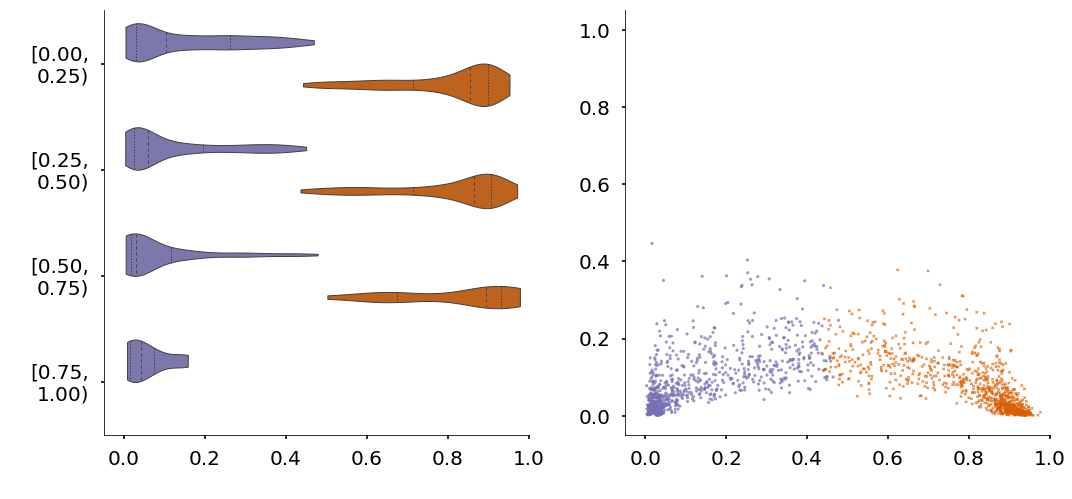

In [13]:
# output
dirname = 'seed_graphs'

fig, axes = init_gridspec(1,2,2)
plot_violin_by_class(axes[0], max_attn, attn_diff, np.array(yhat_preds_orig), xlim=(0, 1.0))
annotate(axes[0], xlim=(-0.05, 1.0), ylabel="Max Attention", xlabel="JSD (seeds vs original)", legend=None)
plot_scatter_by_class(axes[1], attn_diff, y_diff, np.array(yhat_preds_orig))
annotate(axes[1], xlim=(-0.05, 1.0), ylim=(-0.05, 1.05), xlabel="JSD (seeds vs original)", ylabel='Output Difference', legend=None)

adjust_gridspec()
save_axis_in_file(fig, axes[0], dirname, f'{data_name}-lstm-tanh-seed-diffs')
save_axis_in_file(fig, axes[1], dirname, f'{data_name}-lstm-tanh-seed-scatter')
show_gridspec()